In [1]:
import os
import sys 

# Add path to get access to utils folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

### DATA COLLECTION

The raw data is collected from the database called properties stored in MySQL 

In [2]:
from utils.training.functions import mysql_conn
import pandas as pd

# Engine to connect to the database
engine = mysql_conn()

# Get raw data
query = f"SELECT * FROM properties"
raw_data = pd.read_sql(query, engine)

training_date = raw_data['date'].max()
raw_data = raw_data.drop('date', axis=1)

Let's have a look to the metrics of the numeric columns. 

- There are latitudes and longitudes outside the limits of Capital Federal.
- There are samples with outliers in rooms, bedrooms and bathrooms. 
- 14% of the samples are furnished
- Around the 40% have multipurpose room and swimming pool
- 33% have gym
- There are outliers in the price column where the minimum value is $1 and the maximum $888.888.888

In [22]:
raw_data.describe().style.format("{:.2f}").background_gradient()

,latitude,longitude,rooms,bedrooms,full_bathrooms,furnished,has_multipurpose_room,has_swimming_pool,has_gym,price
count,65271.00,65271.00,64568.00,64779.00,64779.00,65459.00,65459.00,65459.00,65459.00,65459.00
mean,-34.60,-58.45,2.79,1.78,1.45,0.02,0.20,0.21,0.13,245678.59
std,0.06,0.10,1.56,1.33,0.91,0.14,0.40,0.41,0.33,4381037.70
min,-38.72,-66.35,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,-34.62,-58.47,2.00,1.00,1.00,0.00,0.00,0.00,0.00,95000.00
50%,-34.60,-58.44,3.00,2.00,1.00,0.00,0.00,0.00,0.00,142000.00
75%,-34.58,-58.41,4.00,3.00,2.00,0.00,0.00,0.00,0.00,229000.00
max,-30.40,-54.33,85.00,42.00,40.00,1.00,1.00,1.00,1.00,888888888.00


For the next code shows the unique values for the string columns:

- The column 'id' is the id of the add in Mercado Libre website and is unique value.
- The samples are only from Capital Federal.
- There are 60 neighborhoods
- The property type could be Departemento (Appartment), Casa (House) or PH (Townhouse)
- The condition could be Nuevo (New) or Usado (Used)
- 'total_area', 'covered_area' and 'parking_lots' are represented as string columns but they must be converted to numeric columns
- 'has_air_conditioning' should be boolean column
- There are samples in USD and ARS. Only properties priced in USD will be considered                       

In [23]:
print(f"{'Column':21}| {'Values'}")
print("-------"*12)

for col in raw_data.select_dtypes('object'):
    unique_values = raw_data[col].dropna().unique()
    n_unique = len(unique_values)
    unique_values_dim = unique_values if n_unique<5 else unique_values[:5]
    unique_values_str = ", ".join(unique_values_dim) if n_unique<5 else (", ".join(unique_values_dim) + ', ..., other ' +f'{n_unique-5}'+' values')
 
    print(f"{col:21}| {unique_values_str}")

Column               | Values
------------------------------------------------------------------------------------
id                   | MLA1885170256, MLA1699425068, MLA1778192622, MLA1811512226, MLA1811073382, ..., other 65454 values
city                 | Capital Federal
neighborhood         | San Cristóbal, Versalles, Villa Real, Velez Sarsfield, La Boca, ..., other 55 values
operation            | Venta
property_type        | Departamento, Casa, Ph
item_condition       | Usado, Nuevo
total_area           | 55 m², 35 m², 47 m², 67 m², 48 m², ..., other 3613 values
covered_area         | 51 m², 31 m², 30 m², 60 m², 43 m², ..., other 3067 values
has_air_conditioning | No, Sí
parking_lots         | [0-0], [2-2], [1-1], [3-*]
currency_id          | USD, ARS


## Null Values

The next code shows the quantity of null values and their percentage over the quantity of samples.
- Only the 'has_air_conditioning' column have around 30% of null values. It could be considered as those samples don't have air conditioning.
- The other columns have just a small porcentage of null values, so they could be imputed. 

In [24]:
null_df = pd.DataFrame(raw_data.isna().sum()[lambda x:x >0],    
                       columns=['Quantity_Nulls'])
                        
null_df['Percentage_Nulls'] = ((null_df['Quantity_Nulls'] / len(raw_data) * 100).round(2))

null_df.sort_values('Quantity_Nulls', ascending=False).style.format("{:.2f}").\
    background_gradient(cmap='PuBu_r', vmin=19, vmax=20, subset=['Percentage_Nulls'])    

,Quantity_Nulls,Percentage_Nulls
has_air_conditioning,19230.00,29.38
item_condition,4103.00,6.27
rooms,891.00,1.36
bedrooms,680.00,1.04
full_bathrooms,680.00,1.04
total_area,680.00,1.04
covered_area,680.00,1.04
latitude,188.00,0.29
longitude,188.00,0.29


### Data Processing

Since some columns are incorrectly cast and there are outliers present, the data will be processed to extract meaningful insights.

The first step is to convert the values in the 'covered_area' and 'total_area' columns to float type

In [25]:
data_proc = raw_data.copy()

import re

for col in ['covered_area', 'total_area']:
        data_proc[col] = data_proc[col].apply(lambda x: \
                                            float(re.sub(r'[^\d.]', '', x)) if pd.notna(x) else x)                        

Certain price values can be considered outliers, specifically those that appear in formats such as 1234567 or 111111. I will identify the IDs of these cases and subsequently remove them from the DataFrame. This step is crucial to ensure that our analysis and model training are not adversely affected by these anomalous entries.

In [26]:
def range_number_finder(number):
    if not isinstance(number, str):
        number = str(number)

    num=[]
    secuence = int(number[0])
    i=0
    while i<len(number):
        num.append(str(secuence))
        secuence+=1
        i+=1

    return "".join(num)

def rep_number_finder(number):
    if not isinstance(number, str):
        number = str(number)

    firts_char = number[0]
    rep_number = firts_char * len(number)
    return rep_number


ids_to_delete = [i for i, c in zip(data_proc['id'],data_proc['price'].astype(str)) if (c == rep_number_finder(c)) | (c==range_number_finder(c))] 

print(f"Samples to delete: {len(ids_to_delete)}")

Samples to delete: 27


In [27]:
data_proc = data_proc[~data_proc.index.isin(ids_to_delete)]

### Outliers

To identify the outliers in the numeric columns, a boxplot will be used. 
But first, the values must to be in the same scale.

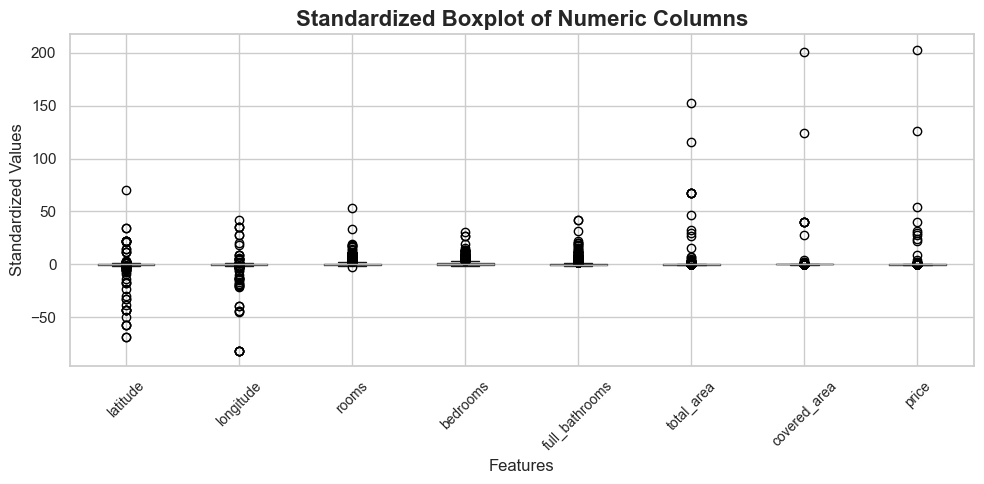

In [28]:
import matplotlib.pyplot as plt

numeric_columns = ['latitude', 'longitude', 'rooms', 'bedrooms', 'full_bathrooms',
                   'total_area', 'covered_area','price']


# Set figure size
plt.figure(figsize=(10, 5))

# Calculate mean and standard deviation
mean = data_proc[numeric_columns].mean()
std = data_proc[numeric_columns].std()

# Create standardized boxplot
((data_proc[numeric_columns] - mean) / std).boxplot()

# Title and labels
plt.title('Standardized Boxplot of Numeric Columns', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Standardized Values', fontsize=12)

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


It’s challenging to interpret the data due to the number of outliers in each column. In this case, we will consider values as outliers if they are lower than the 2.5th percentile or higher than the 97.5th percentile

In [29]:
for col in numeric_columns:
    # Proportion    
    p = 0.05
    # Min and Max values
    min_value = data_proc[col].quantile(p/2)
    max_value = data_proc[col].quantile(1-p/2)
    # Condition to exclude outliers
    filter = ((data_proc[col] >= min_value) & (data_proc[col] <= max_value) )
    # Filtered data
    data_proc = data_proc[filter]

Let’s take another look at the boxplots. By removing the extreme values, the graphs are clearer, allowing us to observe heavy tails in the higher values of the 'rooms,' 'bedrooms,' 'total_area,' 'covered_area,' and 'price' columns

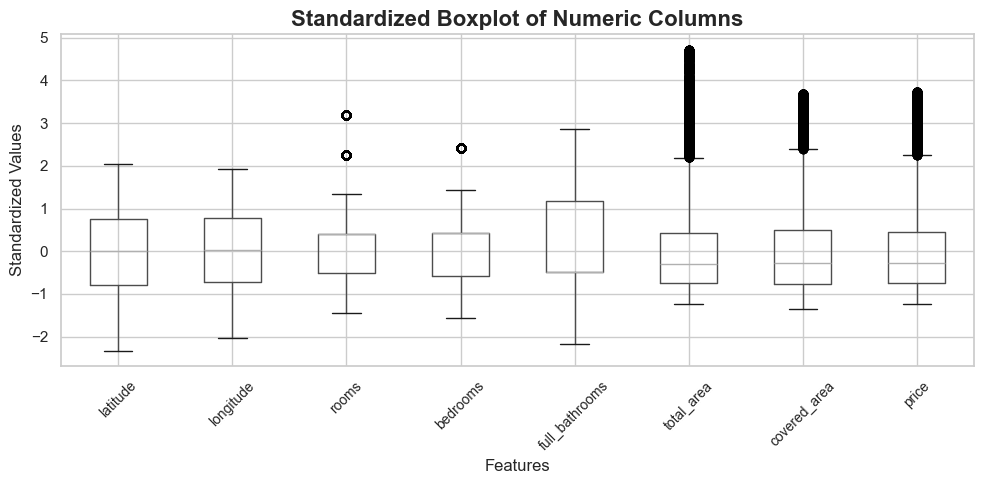

In [30]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 5))

# Calculate mean and standard deviation
mean = data_proc[numeric_columns].mean()
std = data_proc[numeric_columns].std()

# Create standardized boxplot
((data_proc[numeric_columns] - mean) / std).boxplot()

# Title and labels
plt.title('Standardized Boxplot of Numeric Columns', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Standardized Values', fontsize=12)

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


### Correlation

Let's represent the linear correlations between columns to identify any patterns among them. The 'rooms' and 'bedrooms' columns are highly positively correlated, meaning that a higher number of rooms is almost perfectly associated with the number of bedrooms. The relationship between 'total_area' and 'covered_area' also shows a strong positive correlation. Additionally, the correlation between 'rooms' and 'bedrooms' has a moderately high relationship with area. This suggests that some columns may provide similar and redundant information.

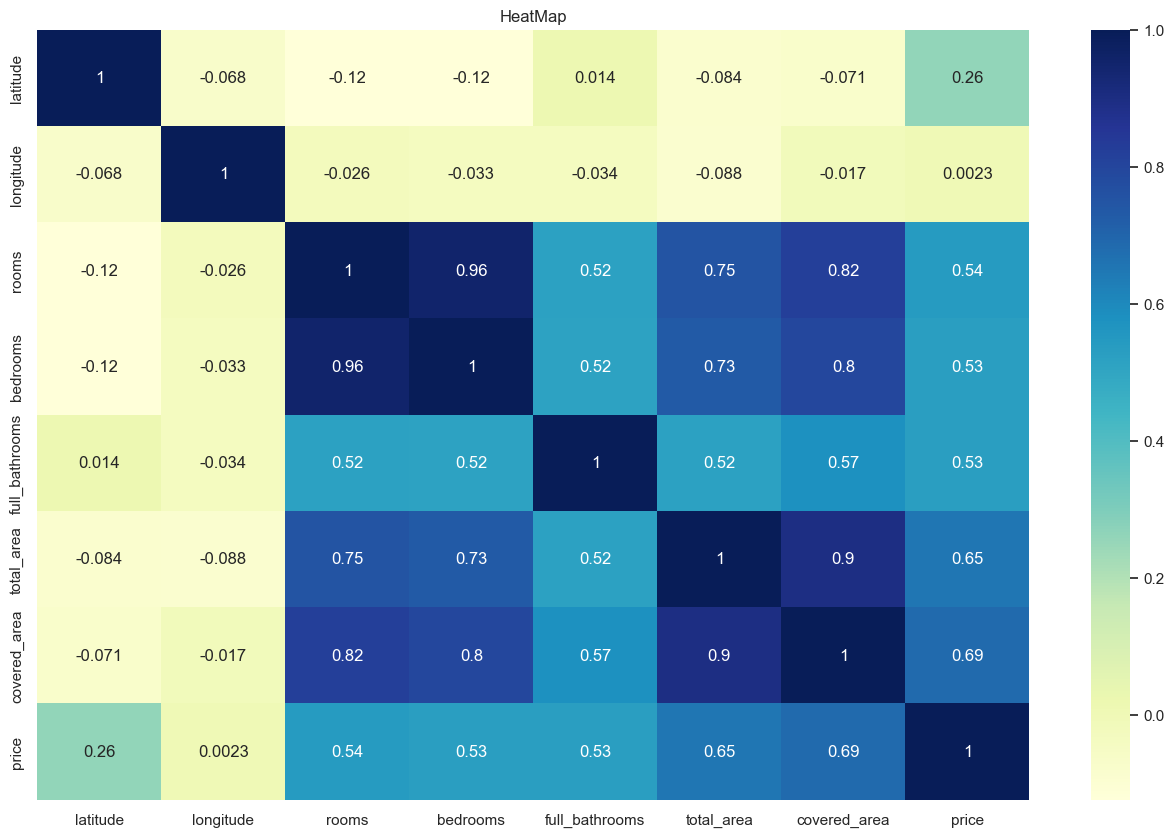

In [31]:
import seaborn as sns

plt.figure(figsize = (16, 10))

sns.heatmap(data_proc[numeric_columns].corr(), annot = True, cmap="YlGnBu")
plt.title('HeatMap')
plt.show()

To explore the linear relationship between price and the other numeric columns, let's plot their trends (Linear Regression of Price Against Numeric Features). It is observed that properties with a greater number of rooms and larger areas tend to have higher prices. Additionally, properties located further north generally have higher prices compared to those in the southern regions

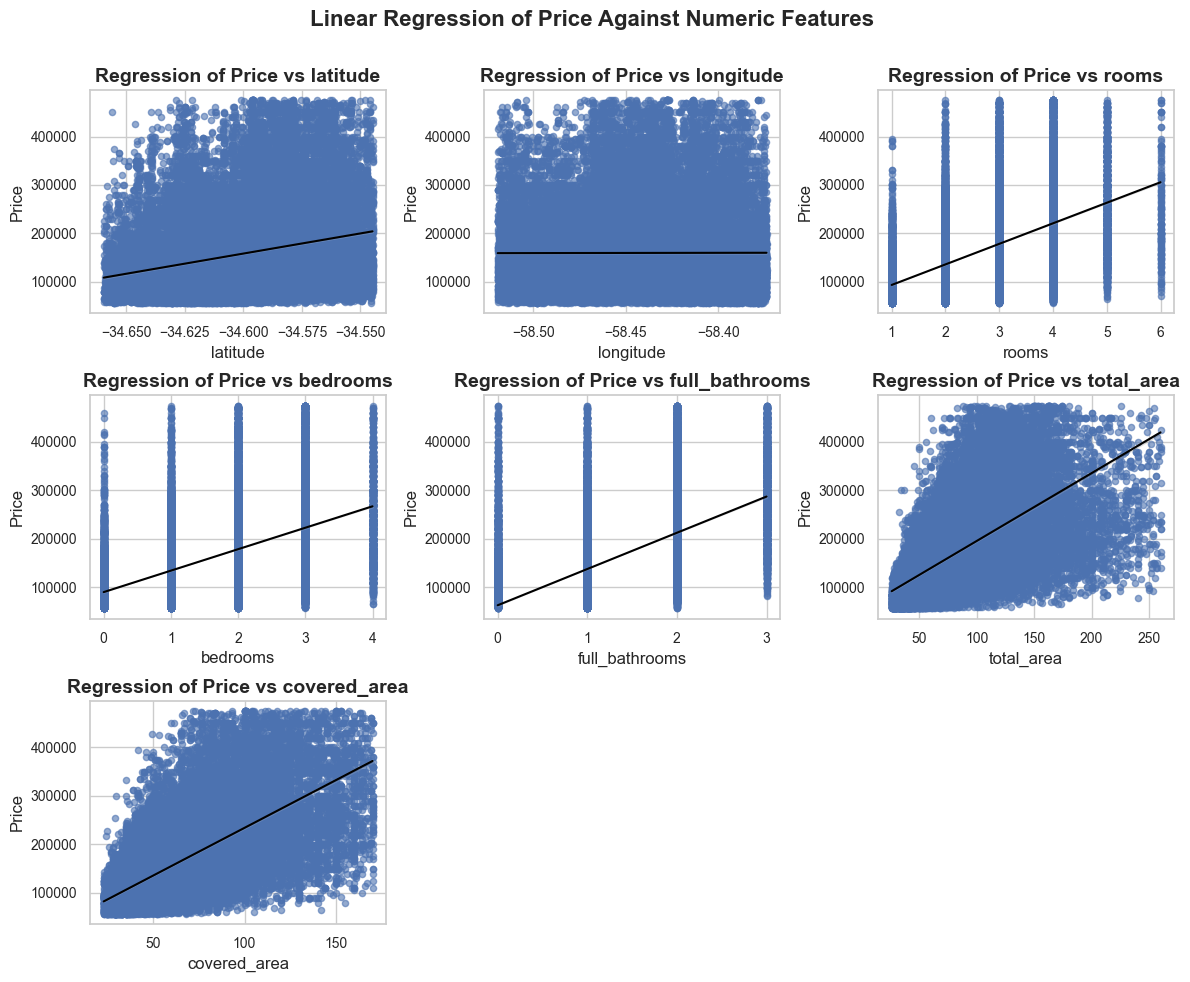

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(12, 10))

for i, col in enumerate(numeric_columns):
    if col != 'price':
        plt.subplot(3, 3, i + 1)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        # Create the regression plot
        sns.regplot(
            x=data_proc[col], 
            y=data_proc['price'], 
            scatter_kws={'s': 20, 'alpha': 0.6}, 
            line_kws={"color": "black", "linewidth": 1.5}
        )
        
        # Set axis labels and title
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.title(f'Regression of Price vs {col}', fontsize=14, fontweight='bold')
        
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin
plt.suptitle('Linear Regression of Price Against Numeric Features', fontsize=16, fontweight='bold')
plt.show()


An important feature for assessing property prices is the price per square meter. To calculate this, we will divide the property's price by its covered area. Next, we will compute the median price per square meter for each neighborhood to mitigate the impact of outliers on this metric

In [33]:
# Calculate m2_price if not already present
if 'm2_price' not in data_proc.columns:
    data_proc['m2_price'] = data_proc.apply(lambda x: int(x['price'] / x['covered_area']) if x['covered_area'] > 0 else None, axis=1)

# Group by neighborhood and calculate median m2_price
neighborhood_m2_price = data_proc.groupby('neighborhood').agg({'m2_price': 'median'}).sort_values(by='m2_price', ascending=False)
data_proc['m2_price_median'] = data_proc['neighborhood'].map(neighborhood_m2_price.to_dict().get('m2_price'))

The median price per square meter will be plot for each neighborhood to highlight the price differences between the most expensive and the least expensive areas

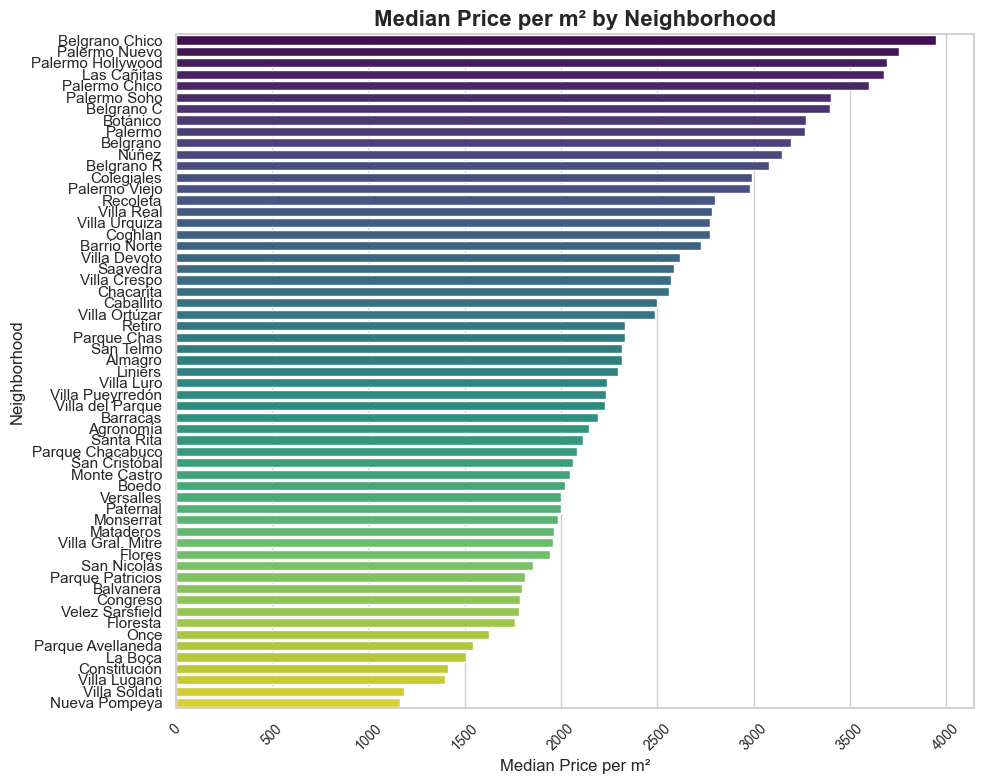

In [34]:

# Set figure size
plt.figure(figsize=(10, 8))

# Create horizontal bar plot
sns.barplot(data=neighborhood_m2_price, y=neighborhood_m2_price.index, x='m2_price', hue=neighborhood_m2_price.index ,legend=False, orient='h', palette='viridis')

# Set labels and title
plt.xlabel('Median Price per m²', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title('Median Price per m² by Neighborhood', fontsize=16, fontweight='bold')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
neighborhood_m2_price.describe().round(0)

,m2_price
count,59.0
mean,2408.0
std,680.0
min,1167.0
25%,1961.0
50%,2297.0
75%,2793.0
max,3947.0


The median price per square meter (m²) across 59 neighborhoods is approximately 2,407.95, with a standard deviation of 679.62, indicating variability in prices. The minimum recorded price per square meter is 1,167, while the maximum reaches 3,947. 

When comparing the most expensive neighborhood to the least expensive, the price per square meter in the most costly area is approximately 238% higher than that in the least expensive neighborhood, highlighting a substantial disparity in property prices across the different neighborhoods

We will use the coordinates and price of each sample to perform clustering, allowing us to identify which regions in Capital Federal are more expensive

        m2_price_median
labels                 
0                2317.0
1                3196.5
2                2147.0


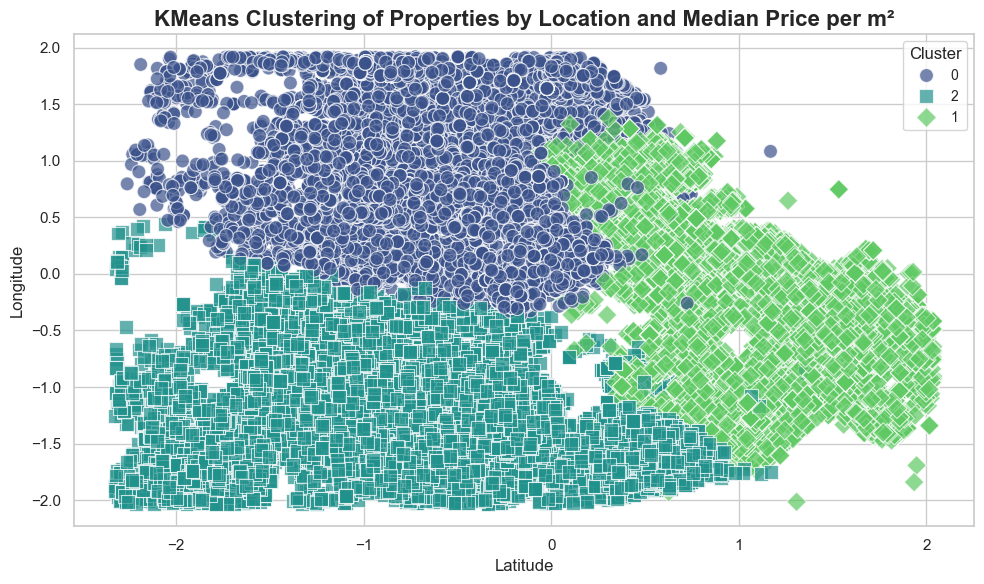

In [36]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
data_cluster = data_proc[['latitude', 'longitude', 'm2_price_median']]

# Standardize the data
mean = data_cluster.mean()
std = data_cluster.std()
standardized_data = (data_cluster - mean) / std

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(standardized_data)

data_proc['labels'] = labels

print(data_proc.groupby('labels').agg({'m2_price_median': 'median'}))

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=standardized_data.assign(label=labels.astype('str')),
    x='latitude',
    y='longitude',
    hue='label',
    palette='viridis',  
    style='label',      
    markers=['o', 's', 'D'],  
    s=100,             
    alpha=0.7          
)

# Set titles and labels
plt.title('KMeans Clustering of Properties by Location and Median Price per m²', fontsize=16, fontweight='bold')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.legend(title='Cluster', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Zone 2, located in the southwest, has the lowest prices in Capital Federal, with a median price of 2,147. Following closely is the northwest zone, with a median price of 2,317. The northeast central zone is the most expensive, with a median price of 3,196.

## TRAIN TEST SPLIT

The dataset will be split into training and testing sets, ensuring that both sets maintain the same distribution of neighborhoods and property types. This approach helps to ensure that the model is trained and evaluated on representative samples, leading to more reliable performance metrics.

In [4]:
from  sklearn.model_selection import train_test_split

# Crear una nueva columna que combine las categóricas
raw_data['combined'] = raw_data['neighborhood'].astype(str) + "_" + raw_data['property_type']
mask = ~raw_data['combined'].isin((raw_data['combined'].value_counts().sort_values(ascending=True) == 1)[lambda x: x==True].index)
raw_data = raw_data[mask]

# Dividir usando la nueva columna combinada
train_dataset, test_dataset = train_test_split(raw_data, test_size=0.2, stratify=raw_data['combined'], random_state=42)

train_dataset.drop('combined', axis=1, inplace=True)
test_dataset.drop('combined', axis=1, inplace=True)

### Pipeline

To ensure that the data undergoes the same transformation process for both training and testing, it will go through a comprehensive data transformation pipeline incorporating all the previously evaluated points. The pipeline consists of seven steps:

DataProcessing: This step filters for properties expressed in USD, removes invariant columns such as currency_id, city, and operation, and casts columns to the appropriate formats.

RemoveOutliers: Samples will be filtered to include only those within the coordinates of Capital Federal, with a maximum of 10 rooms, 9 bedrooms, 9 bathrooms, a total area of 1500 m², a covered area of up to 1000 m², and prices ranging from 40,000 to 5,000,000.

DensityEstimator: This step calculates the density of nearby amenities such as banks, schools, restaurants, bars, and public transport services for each sample within a 100-meter radius.

FeatureEngineering: Highly correlated columns will be removed, and the median price per square meter will be calculated for each sample, along with the average square meters per room.

DataImputer: Missing values will be imputed based on other columns.

Scaler: A MinMaxScaler will be applied to standardize the data.

OneHotEncoding: String columns will be converted to one-hot encoding, except for the neighborhood column, which will be removed from the dataframe.

In [5]:
from sklearn.pipeline import Pipeline
from utils.training.classes import DataProcessing, FeatureEngineering, DataImputer, DensityEstimator, OneHotEncoding, LogScale, Scaler, RemoveOutliers ,PCA_


column_dict = {'rooms'          : ['bedrooms', 'full_bathrooms'],
               'bedrooms'       : ['rooms', 'full_bathrooms'],
               'full_bathrooms' : ['rooms', 'bedrooms'],
               'neighborhood'   : ['latitude', 'longitude'],
               'total_area'     : ['rooms', 'bedrooms'],
               'covered_area'   : ['rooms', 'bedrooms']
                }

pipeline = Pipeline([
    ('data_proces', DataProcessing()),
    ('remove_outliers', RemoveOutliers()), 
    ('density', DensityEstimator(stage='train')),
    ('feature_eng', FeatureEngineering()),
    ('imputer', DataImputer(column_dict)),
    ('scaler', Scaler('MinMaxScaler')),
    ('ohe', OneHotEncoding())
])

pipeline.fit(train_dataset)

transformed_train_dataset = pipeline.transform(train_dataset)
transformed_test_dataset  = pipeline.transform(test_dataset)

Let's verify if the pipeline works well:

In [39]:
print(f"- Number of columns: {len(transformed_train_dataset.columns)}")

if len(transformed_train_dataset.columns)== len(transformed_test_dataset.columns):
    print("- Training and Testing dataset have same number of columns")

if all((transformed_train_dataset.columns)==(transformed_test_dataset.columns)):
    print("- Training and Testing dataset have same columns")

if (transformed_train_dataset.isna().sum().sum() == transformed_test_dataset.isna().sum().sum()) & (transformed_train_dataset.isna().sum().sum()==0):
    print("- There are not null values")

- Number of columns: 31
- Training and Testing dataset have same number of columns
- Training and Testing dataset have same columns
- There are not null values


## Training

To train the model, we will utilize Linear Regression, Random Forest, and Gradient Boosting Machine (GBM) algorithms. We will optimize the hyperparameters for each model using 10-fold cross-validation on a predefined grid of hyperparameters. This approach ensures that we comprehensively evaluate the performance of different hyperparameter combinations, leading to improved model accuracy and robustness

In [9]:
# Params for the models
param_grids = {
    'LinearRegression': {
        'fit_intercept': [True, False]
    },
    'Random Forest': {
        'n_estimators': [3000, 5000],
        'max_depth': [7, 10]
    },
    'GBM': {
        'n_estimators': [1000, 2000],
        'learning_rate': [0.01],
        'max_depth': [7, 10]
    }
}


In [48]:
from utils.training.classes import Trainer

trainer = Trainer(model_name='LinearRegression',
                  test_dataset=transformed_test_dataset,
                  cv=10, 
                  param_grids=param_grids)

lr_results = trainer.train(transformed_train_dataset)
lr_results

{'best_params': {}, 'train_cv_rmse': 75427.049, 'test_rmse': 75590.838}

In [8]:
trainer = Trainer(model_name='RandomForest',
                  test_dataset=transformed_test_dataset,  
                  cv=10, 
                  param_grids=param_grids)

rf_results = trainer.train(transformed_train_dataset)
rf_results

{'best_params': {'max_depth': 10, 'n_estimators': 3000},
 'train_cv_mae': 44867.0,
 'test_mae': 45847.0}

In [10]:
trainer = Trainer(model_name='GBM',
                  test_dataset=transformed_test_dataset,
                  cv=10,
                  param_grids=param_grids)

gbm_results = trainer.train(transformed_train_dataset)
gbm_results

{'best_params': {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 3000},
 'train_cv_mae': 39766.0,
 'test_mae': 40215.0}

After training the Linear Regression, Random Forest, and Gradient Boosting Machine (GBM) models, all exhibited low variance, indicating stable performance across different folds of cross-validation. Among them, the GBM model demonstrated the best bias-variance tradeoff, achieving the lowest bias. The GBM model's performance was optimized using the following hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 3000}. This model achieved a cross-validation Mean Absolute Error (MAE) of 39,766 on the training set and 40,215 on the test set, indicating consistent performance and strong predictive accuracy.

### Best Model

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

X = transformed_train_dataset.drop(['price'], axis=1)
y = transformed_train_dataset['price']

gbm = GradientBoostingRegressor(**gbm_results['best_params'])

gbm.fit(X, y) 

X_test = transformed_test_dataset.drop(['price'], axis=1)
y_test = transformed_test_dataset['price']

y_pred = pd.Series(gbm.predict(X_test), 
                   index = y_test.index,
                   name='pred')


The Mean Absolute Percentage Error (MAPE) and R² Score are two important metrics to evaluate model performance.

MAPE measures the average percentage difference between predicted and actual values. It's a useful metric because it expresses errors as a percentage, making it easier to interpret across different datasets. In this case, the MAPE provides a clear sense of how far off, on average, the model's predictions are from the actual values relative to the true values. Lower MAPE values indicate better model performance. For instance, if the MAPE is 0.12 (or 12%), the model's predictions are, on average, 12% off from the actual values.

R² Score indicates how well the model explains the variance in the target variable. In this case the R² is 85%

In [72]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Absolut Percentage Error (MAPE): {mape.round(2)*100}%')
print(f'R^2 Score: {round(r2, 2)*100}%')

Root Absolut Percentage Error (MAPE): 18.0%
R^2 Score: 85.0%


The scatter plot comparing the predicted and actual test values shows a decent fit between the model's predictions and the real data points. In the plot, most predictions align well with the actual values, especially for lower and mid-range values. This indicates that the model performs adequately across a majority of the data.

However, for higher values, the variance increases, meaning the predictions deviate more from the actual values. This can be observed as the points scatter further from the ideal diagonal line (which represents a perfect prediction). In other words, the model tends to struggle with higher-priced properties, leading to greater prediction errors for these cases.

This behavior might suggest that the model has more difficulty capturing the underlying patterns for high-value properties, potentially due to fewer high-value samples in the data or more complex relationships that the model is not fully capturing.

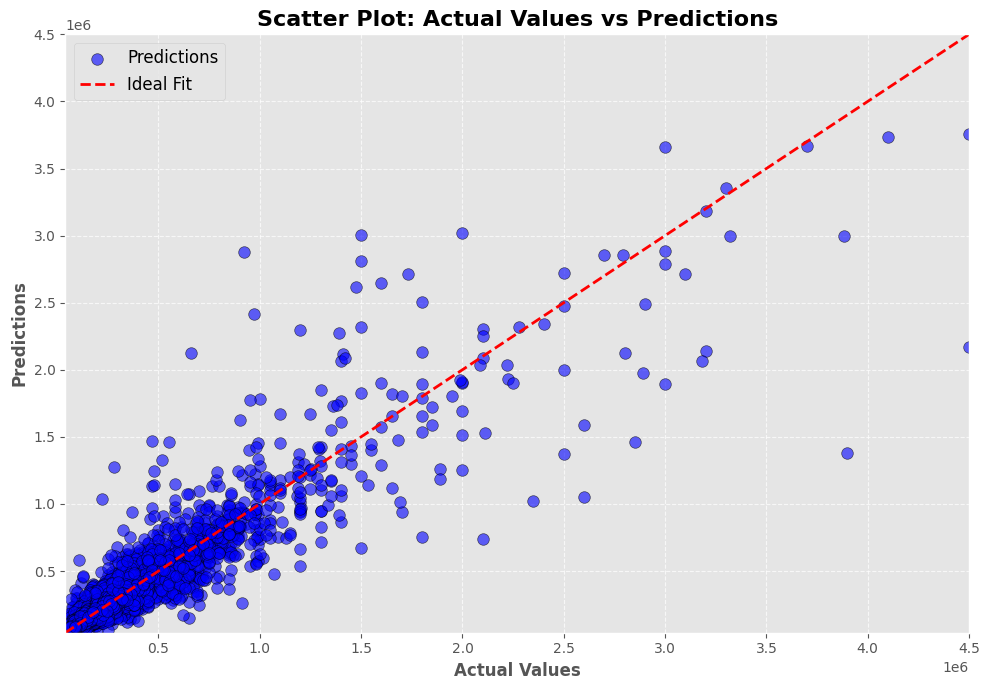

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern style for the plot
plt.style.use('ggplot')

# Create the figure and adjust its size
plt.figure(figsize=(10, 7))

# Scatter plot with custom marker size and transparency
plt.scatter(y_test, y_pred, color='b', alpha=0.6, edgecolors='k', s=70, label='Predictions')

# Plot the reference line (ideal predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values', fontsize=12, fontweight='bold')
plt.ylabel('Predictions', fontsize=12, fontweight='bold')
plt.title('Scatter Plot: Actual Values vs Predictions', fontsize=16, fontweight='bold')

# Add grid and adjust axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])

# Add legend to explain the lines and points
plt.legend(fontsize=12)

# Improve spacing in the layout
plt.tight_layout()

# Display the plot
plt.show()


It will be calculated the Mean Absolute Percentage Error (MAPE) for different price ranges to better understand where the model tends to make larger errors. By segmenting the data into various price brackets, we can identify in which ranges the model performs well and in which it struggles. This will help us determine whether the model has difficulty predicting lower, mid-range, or higher property prices, allowing for more targeted improvements or adjustments to the model.


In [71]:
def mape_function(y_true, y_pred):
    return ((y_true - y_pred) / y_true).abs().mean().round(2)

mask = test_dataset.index.isin(y_pred.index)

test_result=pd.concat([test_dataset.loc[mask, ['neighborhood']],
           y_pred.round(0).astype(int),
           y_test], axis=1)

test_result['price_bins'] = pd.Series(pd.cut(y_test, y_test.quantile([0, 0.1, 0.25, 0.5, 0.75, 1])))

test_result.groupby(['price_bins'],observed=False).agg(
    mape=('price', lambda x: mape_function(x, test_result.loc[x.index, 'pred'])), 
    size=('price', lambda x: round(len(x)/len(test_result), 3))  
).sort_index()

,mape,size
price_bins,,
"(40000.0, 75000.0]",0.27,0.100
"(75000.0, 105000.0]",0.20,0.153
"(105000.0, 155000.0]",0.16,0.248
"(155000.0, 244407.25]",0.15,0.247
"(244407.25, 4500000.0]",0.18,0.250


For properties priced above $105,000, the MAPE is approximately 17%, which indicates that the model maintains a reasonable level of accuracy for the majority of the dataset, as this price range represents about 75% of the total data. However, for properties priced below $105,000, the MAPE tends to increase, reflecting a higher error rate. This is likely due to the fact that the proportion of data in these lower price ranges is smaller, meaning the model has less data to learn from, leading to less accurate predictions for these cases.


I will also calculate the MAPE by neighborhood to understand how prediction errors vary across different areas. This analysis will provide a prediction error factor for each neighborhood, which can be used to offer a more accurate range of predicted prices. By incorporating neighborhood-specific errors, we can present a more realistic and localized prediction range, improving the model's reliability for end-users.

In [45]:
neighborhood_var = test_result.groupby(['neighborhood']).apply(lambda x: mape_function(x['price'], x['pred']),  include_groups=False).sort_values()

neighborhood_var.sort_values()

neighborhood
Versalles            0.13
Almagro              0.15
Parque Chas          0.15
Palermo Hollywood    0.15
Villa Urquiza        0.15
Caballito            0.16
Belgrano             0.16
Belgrano C           0.16
Floresta             0.16
Las Cañitas          0.16
Villa del Parque     0.16
Palermo Soho         0.16
San Cristóbal        0.16
Villa Crespo         0.16
Villa Real           0.16
Agronomía            0.16
Núñez                0.16
Barrio Norte         0.17
Santa Rita           0.17
Saavedra             0.17
Coghlan              0.17
Belgrano R           0.17
Colegiales           0.17
Liniers              0.17
Palermo Nuevo        0.18
Villa Devoto         0.18
Boedo                0.18
Belgrano Chico       0.18
Congreso             0.18
Palermo              0.18
Monte Castro         0.18
Villa Gral. Mitre    0.19
Villa Luro           0.19
Parque Patricios     0.19
Villa Pueyrredón     0.19
Balvanera            0.19
Flores               0.19
Villa Ortúzar        0.20

I will create a plot to visualize the importance of variables, highlighting that the most significant factors in our predictions are the coordinates (latitude and longitude), total area, and price per square meter. This analysis will help us understand which features contribute most to the model's predictive power, guiding future feature selection and engineering efforts

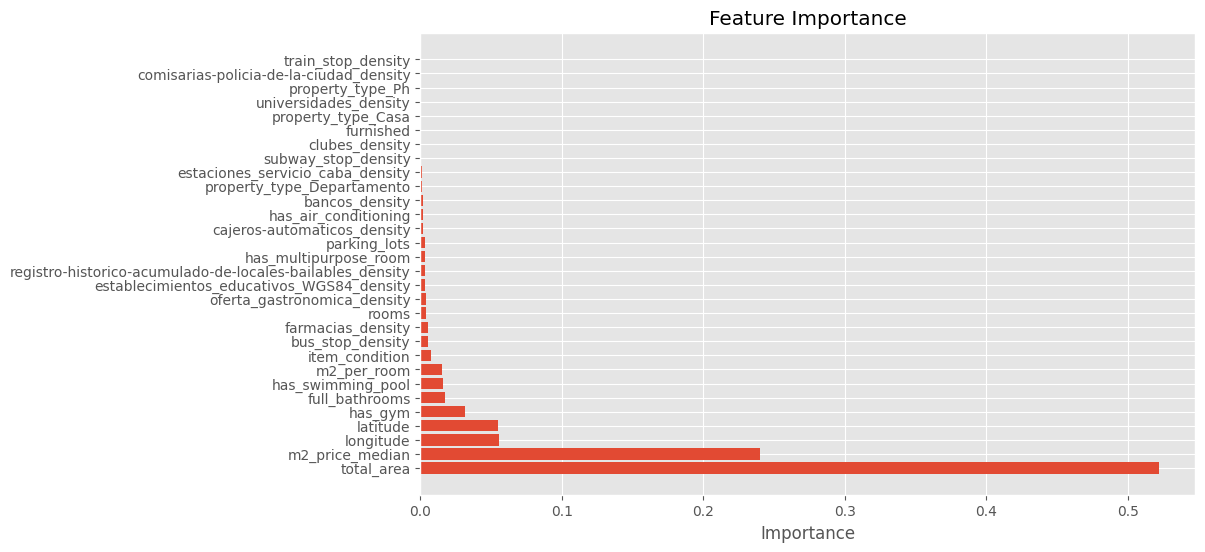

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

importances = gbm.feature_importances_
feature_names = transformed_train_dataset.columns.drop('price')

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


The model, along with the transformation pipeline and the variability factors for each neighborhood, will be saved for production use. This ensures that we can reliably deploy the model to make predictions on new data while maintaining the same preprocessing steps and accounting for regional variations in pricing. By storing these components, we can streamline the prediction process and ensure consistency in our outputs when the model is utilized in real-world applications.

In [15]:
import os

dir_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

if 'model' not in os.listdir(dir_path):
    os.mkdir(dir_path+'/model')

model_path = os.path.join(dir_path, 'model')

if not os.listdir(model_path):
    version = '1'
    model_path_version = os.path.join(model_path, version)
    os.mkdir(model_path_version)
else:
    last_versions = max([int(v) for v in os.listdir(model_path)])


In [90]:
mae = gbm_results['test_mae']

model_residual = {'date':training_date,
                  'mae': mae,
                  'mape': mape}

In [87]:
import joblib

# Save the pipeline
joblib.dump(pipeline, os.path.join(model_path_version, 'pipeline.pkl'))
# Save the Model
joblib.dump(gbm, os.path.join(model_path_version, 'model.pkl')) 
# Save the factors
joblib.dump(neighborhood_var,  os.path.join(model_path_version, 'neighborhood_var.pkl'))
# Save the model residuals
joblib.dump(model_residual,  os.path.join(model_path_version, 'model_residual.pkl'))

['c:\\Users\\User\\Desktop\\valen\\Property_Prediction\\model\\1\\model_residual.pkl']